<div>
<img src="https://www.nebrija.com/images/logos/logotipo-universidad-nebrija.jpg" width="200">
</div>

**MODELOS DE PROGRAMACION: MODELO ADIABATICO** -
Prof: Carmen Pellicer Lostao

# CSP DIET PLANNING

## EXERCICE

In this exercice you have to implement a **DIET PLANNER** application following this  example: https://docs.ocean.dwavesys.com/en/stable/examples/hybrid_cqm_diet.html in the examples repository of DWave's OCEAN SDK

The example will guide you on the code to build a **Constrained Quadratic Model (CQM)** and solve it in the **Leap hybrid Constrained Quadratic Models (CQM) solver**

### REQUIEREMENTS FOR YOUR DIET PLANNER

The Diet Planner that you must develop will have:

- a list of your own foods
- your own constraints on bound values of the foods

Given the above own diet you must:

- solve the problem in the LeapHybridCQMSampler
- tune the result to find good values for the parameters that scale the two parts of the optimizing function (taste and cost)

### Additional remarks

Document your notebook describing with text cells all assumptions and definitions that you are using, as well as comment your code cells accordingly.

### DIET PLANNER

#### Planteamiento del problema

Supongamos que debemos realizar un menú para un solo día en un comedor escolar. No solo tendremos que tener en cuenta el coste de los alimentos que usemos durante la semana, sino que, además, es necesario que los niños del comedor tengan una alimentación saludable y deseable (en la medida de lo posible). Para ello, realizamos una encuesta a los alumnos. Vista las preferencias, hemos optado por considerar los siguientes alimentos base:

|Alimento | Calorías | Proteínas | Grasas | Carbohidratos | Fibra | Deseabilidad | Coste |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| Mandarinas | 50 | 1 | 0.5 | 14 | 2 | 6 | 2 |
| Patatas | 100 | 2 | 2 | 20 | 3 | 7 | 1.5 |
| Hamburguesas de cerdo | 300 | 13 | 20 | 7 | 2 | 10 | 2.5 |
| Ensalada variada | 70 | 2 | 0 | 3 | 4 | 5 | 1 |
| Arroz | 180 | 3 | 0 | 28 | 1 | 6 | 1 |
| Pan | 150 | 8 | 3 | 40 | 8 | 5 | 0.5 |
| Huevos | 120 | 13 | 10 | 0.5 | 0 | 4 | 2 |

Consideraremos además las siguientes restricciones:

- Las calorías no podrán ser mayores que 1200.
- Al menos 40g de proteínas.
- Al menos 20g de grasa, pero no más de 50g.
- Al menos 80g de carbohidratos.
- Al menos 10g de fibra.

#### Variables

Con todo, empezamos a resolver el modelo. Para ello, comenzaremos formulando el problema como un CQM.

In [2]:
import dimod
from dwave.system import LeapHybridCQMSampler
import numpy as np
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt

In [3]:
# Guardamos todos los datos para la creación de variables y restricciones. 
# Unidad hace referencia a si el alimento se compra por unidades o si existe la posibilidad de fraccionarlo, como por ejemplo, 1.5Kg de arroz (continuo) frente a 3 huevos (discreto).
alimentos = {
  'mandarinas': {'Calorias': 50, 'Proteinas': 1, 'Grasas': 0.5, 'Carbohidratos': 14, 'Fibra': 2,
           'Deseabilidad': 6, 'Coste': 2, 'Unidad': 'discreto'},
  'patatas': {'Calorias': 100, 'Proteinas': 2, 'Grasas': 2, 'Carbohidratos': 20, 'Fibra': 3,
           'Deseabilidad': 7, 'Coste': 1.5, 'Unidad': 'discreto'},
  'hamburguesas de cerdo': {'Calorias': 200, 'Proteinas': 10, 'Grasas': 15, 'Carbohidratos': 7, 'Fibra': 2,
           'Deseabilidad': 10, 'Coste': 2, 'Unidad': 'discreto'},
  'ensalada variada': {'Calorias': 70, 'Proteinas': 2, 'Grasas': 0, 'Carbohidratos': 3, 'Fibra': 4,
           'Deseabilidad': 5, 'Coste': 1, 'Unidad': 'continuo'},
  'arroz': {'Calorias': 180, 'Proteinas': 3, 'Grasas': 0, 'Carbohidratos': 28, 'Fibra': 1,
           'Deseabilidad': 6, 'Coste': 1, 'Unidad': 'continuo'},
  'pan': {'Calorias': 150, 'Proteinas': 8, 'Grasas': 3, 'Carbohidratos': 40, 'Fibra': 8,
           'Deseabilidad': 5, 'Coste': 0.5, 'Unidad': 'continuo'},
  'huevos': {'Calorias': 120, 'Proteinas': 13, 'Grasas': 10, 'Carbohidratos': 0.5, 'Fibra': 0,
           'Deseabilidad': 4, 'Coste': 2, 'Unidad': 'discreto'}}

min_nutrientes = {"Proteinas": 40, "Grasas": 20, "Carbohidratos": 80, "Fibra": 10}
max_grasas = 50
max_calorias = 1200

In [4]:
# Creamos las variables según sean discretas o continuas:
variables = [dimod.Real(f"{comida}") if alimentos[comida]["Unidad"] == "continuo"
                                    else dimod.Integer(f"{comida}")
                                    for comida in alimentos.keys()]

Mostremos las variables.

In [5]:
variables

[QuadraticModel({'mandarinas': 1.0}, {}, 0.0, {'mandarinas': 'INTEGER'}, dtype='float64'),
 QuadraticModel({'patatas': 1.0}, {}, 0.0, {'patatas': 'INTEGER'}, dtype='float64'),
 QuadraticModel({'hamburguesas de cerdo': 1.0}, {}, 0.0, {'hamburguesas de cerdo': 'INTEGER'}, dtype='float64'),
 QuadraticModel({'ensalada variada': 1.0}, {}, 0.0, {'ensalada variada': 'REAL'}, dtype='float64'),
 QuadraticModel({'arroz': 1.0}, {}, 0.0, {'arroz': 'REAL'}, dtype='float64'),
 QuadraticModel({'pan': 1.0}, {}, 0.0, {'pan': 'REAL'}, dtype='float64'),
 QuadraticModel({'huevos': 1.0}, {}, 0.0, {'huevos': 'INTEGER'}, dtype='float64')]

Recordemos que tenemos unos valores máximos de calorías y grasas. Así, los alimentos estarán sujetos a una cantidad máxima. Definimos estas con el código que sigue.

In [6]:
# Cantidad máxima de alimentos por calorías y grasas
for ind, comida in enumerate(alimentos.keys()):
  ub_cal = max_calorias / alimentos[comida]["Calorias"]
  if alimentos[comida]['Grasas'] == 0:
    ub_gra = 1000 # Si el alimento no tiene grasas, podríamos escoger la cantidad que queramos
  else:
    ub_gra = max_grasas / alimentos[comida]["Grasas"]
  ub = min(ub_cal,ub_gra) # Tomamos la que sea más restrictiva de las cotas
  variables[ind].set_upper_bound(comida, ub)

Veamos un ejemplo.

In [7]:
variables[0].upper_bound("mandarinas") # Número máximo de mandarinas permitidas: 25*50 = 1250, mientras que 25*0.5 = 12.5 < 50 (máximo de grasas)

24.0

Como vemos, podríamos tener un máximo de 20 mandarinas. Dado que no tiene mucho sentido esto, cambiaremos el valor manualmente para que dicho máximo sea, por ejemplo, 2.

In [8]:
variables[0].set_upper_bound('mandarinas',2)
variables[3].set_upper_bound('ensalada variada',2)

#### Función Objetivo

Tal y como se muestra en el documento referido a este problema en el repositorio de DWave, la función objetivo debe reflejar que minimizaremos el coste y maximizaremos la preferencia de los alumnos. Esto es:

$$
f(x) = \alpha \sum_{i=1}^7c_{i}q_{i} - \beta \sum_{i=1}^7p_iq_i
$$
es la función objetivo a minimizar. En ella, denotamos a las variables por $q_i$, con coste asociado $c_i$ y valor de preferencia $p_i$, para todo $i\in\{1,\cdots,7\}$. Los valores de $\alpha$, $\beta \in \mathbb{R}^+$ están relacionados con el peso de cada tarea por separado. Si, por ejemplo, queremos priorizar que los alumnos estén contentos con el menú, podemos considerar $\beta > \alpha$.

Creemos entonces nuestro CQM.

In [9]:
cqm = dimod.ConstrainedQuadraticModel()

In [10]:
# Definimos una función que nos ayude en la creación de los sumatorios vistos
def sumatorio_diet(variable, categoria):
  return sum(q * c for q, c in zip(variable, (alimentos[comida][categoria] for comida in alimentos.keys())))

# Definimos la función objetivo
cqm.set_objective(sumatorio_diet(variables,'Coste') - 2*sumatorio_diet(variables,'Deseabilidad'))

En este caso, le damos prioridad al deseo de los alumnos considerando $\alpha = 1$ y $\beta = 2$.

#### Restricciones

Veamos cada restricción a añadir:

In [11]:
# Máximo de calorías
cqm.add_constraint(sumatorio_diet(variables,'Calorias') <= max_calorias,label = 'R_Calorias')

# Mínimo de proteínas
cqm.add_constraint(sumatorio_diet(variables,'Proteinas') >= min_nutrientes['Proteinas'],label = 'R_Proteinas')

# Mímino de grasas
cqm.add_constraint(sumatorio_diet(variables,'Grasas') >= min_nutrientes['Grasas'],label = 'R_Grasas_min')

# Máximo de grasas
cqm.add_constraint(sumatorio_diet(variables,'Grasas') <= max_grasas,label = 'R_Grasas_max')

# Mímino de carbohidratos
cqm.add_constraint(sumatorio_diet(variables,'Carbohidratos') >= min_nutrientes['Carbohidratos'],label = 'R_Carbohidratos')

# Mímino de fibra
cqm.add_constraint(sumatorio_diet(variables,'Fibra') >= min_nutrientes['Fibra'],label = 'R_Fibra')


'R_Fibra'

Comprobemos que se ha hecho todo correctamente imprimiendo las restricciones.

In [12]:
for ind in ['R_Calorias','R_Proteinas','R_Grasas_min','R_Grasas_max','R_Carbohidratos','R_Fibra']:
    print(f'{ind}: {cqm.constraints[ind].to_polystring()}')

R_Calorias: 50*mandarinas + 100*patatas + 200*hamburguesas de cerdo + 70*ensalada variada + 180*arroz + 150*pan + 120*huevos <= 1200.0
R_Proteinas: mandarinas + 2*patatas + 10*hamburguesas de cerdo + 2*ensalada variada + 3*arroz + 8*pan + 13*huevos >= 40.0
R_Grasas_min: 0.5*mandarinas + 2*patatas + 15*hamburguesas de cerdo + 0*ensalada variada + 0*arroz + 3*pan + 10*huevos >= 20.0
R_Grasas_max: 0.5*mandarinas + 2*patatas + 15*hamburguesas de cerdo + 0*ensalada variada + 0*arroz + 3*pan + 10*huevos <= 50.0
R_Carbohidratos: 14*mandarinas + 20*patatas + 7*hamburguesas de cerdo + 3*ensalada variada + 28*arroz + 40*pan + 0.5*huevos >= 80.0
R_Fibra: 2*mandarinas + 3*patatas + 2*hamburguesas de cerdo + 4*ensalada variada + arroz + 8*pan + 0*huevos >= 10.0


#### Resolución con solver híbrido

A continuación resolveremos el CQM usando un solver híbrido.

In [13]:
# Definimos el sampler
sampler = LeapHybridCQMSampler()

# Resolvemos el CQM
sampleset = sampler.sample_cqm(cqm)

# Tomamos las soluciones factibles
feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)   

# Imprimimos el número de soluciones factibles
print("{} soluciones factibles de {}.".format(len(feasible_sampleset), len(sampleset))) 

100 soluciones factibles de 118.


In [14]:
def print_diet(sample):
   dieta = {comida: round(cantidad, 1) for comida, cantidad in sample.items()}
   print(f"Dieta: {dieta}")
   taste_total = sum(alimentos[comida]["Deseabilidad"] * cantidad for comida, cantidad in sample.items())
   cost_total = sum(alimentos[comida]["Coste"] * cantidad for comida, cantidad in sample.items())
   print(f"Deseabilidad de {round(taste_total, 2)} con coste {round(cost_total, 2)}")
   for constraint in cqm.iter_constraint_data(sample):
      print(f"{constraint.label} (nominal: {constraint.rhs_energy}): {round(constraint.lhs_energy)}")

best = feasible_sampleset.first.sample
print_diet(best)                                   

Dieta: {'arroz': 0.0, 'ensalada variada': 1.1, 'hamburguesas de cerdo': 1.0, 'huevos': 1.0, 'mandarinas': 2.0, 'pan': 0.0, 'patatas': 7.0}
Deseabilidad de 80.71 con coste 19.64
R_Calorias (nominal: 1200.0): 1200
R_Proteinas (nominal: 40.0): 41
R_Grasas_min (nominal: 20.0): 40
R_Grasas_max (nominal: 50.0): 40
R_Carbohidratos (nominal: 80.0): 179
R_Fibra (nominal: 10.0): 32


En esta solución obtenemos un menú fundamentado en las patatas. Por lo general, se incluyen todos los alimentos salvo el arroz y el pan.

#### Tuning de la solución

Como hemos mencionado, se han considerado valores concretos para los coeficientes de $\alpha$ y $\beta$ en la solución anterior. Veamos los cambios que ocurren al considerar otros valores. Por ejemplo, supongamos que queremos priorizar solamente la deseabilidad del alumno ($\alpha = 0$ y $\beta = 1$). Resolvamos el nuevo CQM:

In [15]:
# Definiremos primero una función que nos cree la función objetivo en función de alpha y beta
def tuning_obj(alpha,beta):
    return alpha*sumatorio_diet(variables,'Coste') - beta*sumatorio_diet(variables,'Deseabilidad')

cqm.set_objective(tuning_obj(0,1)) # Redefinimos el CQM
sampleset = sampler.sample_cqm(cqm)
feasible_sampleset_deseable = sampleset.filter(lambda row: row.is_feasible)
best = feasible_sampleset_deseable.first.sample
print_diet(best)

Dieta: {'arroz': 0.0, 'ensalada variada': 1.1, 'hamburguesas de cerdo': 1.0, 'huevos': 1.0, 'mandarinas': 2.0, 'pan': 0.0, 'patatas': 7.0}
Deseabilidad de 80.71 con coste 19.64
R_Calorias (nominal: 1200.0): 1200
R_Proteinas (nominal: 40.0): 41
R_Grasas_min (nominal: 20.0): 40
R_Grasas_max (nominal: 50.0): 40
R_Carbohidratos (nominal: 80.0): 179
R_Fibra (nominal: 10.0): 32


La solución es prácticamente la misma de antes, por lo que cabe preguntarse qué ocurriría si aumentamos la importancia del coste. ¿Cuál es la solución menos costosa?

In [16]:
cqm.set_objective(tuning_obj(1,0)) # Redefinimos el CQM quitando la deseabilidad y centrándonos en el coste
sampleset = sampler.sample_cqm(cqm)
feasible_sampleset_coste = sampleset.filter(lambda row: row.is_feasible)
best = feasible_sampleset_coste.first.sample
print_diet(best)

Dieta: {'arroz': 0.0, 'ensalada variada': 0.0, 'hamburguesas de cerdo': 0.0, 'huevos': 0.0, 'mandarinas': 0.0, 'pan': 6.7, 'patatas': 0.0}
Deseabilidad de 33.33 con coste 3.33
R_Calorias (nominal: 1200.0): 1000
R_Proteinas (nominal: 40.0): 53
R_Grasas_min (nominal: 20.0): 20
R_Grasas_max (nominal: 50.0): 20
R_Carbohidratos (nominal: 80.0): 267
R_Fibra (nominal: 10.0): 53


Como vemos, el menú más barato es el que solamente cuenta con pan. Si quisiéramos saber la mínima energía de todas las soluciones factibles podemos ejecutar el siguiente código:

In [17]:
energia_min = min(feasible_sampleset_coste.to_serializable().get("vectors").get("energy").get("data"))
print(energia_min)

3.333333333333333


Podemos estudiar la evolución de las energías en función de los coeficientes de cada parte (coste y deseabilidad). En nuestro caso, hemos optado por considerar $\beta=1$ fijado y variar $\alpha$ de 0 a 20. En el siguiente bucle se resuelven todos esos porblemas y se almacenan los datos que queremos: Energía mínima de la mejor solución, aportación de la parte de coste y aportación de la parte de deseabilidad. Debido a la cantidad de problemas, el tiempo de ejecución es relativamente considerable.

In [28]:
vector_graf = []
for ind in range(0,21):
    cqm.set_objective(tuning_obj(ind,1)) # En cada iteración se aumenta la importancia de la deseabilidad
    sampleset = sampler.sample_cqm(cqm)
    feasible_sampleset_graf = sampleset.filter(lambda row: row.is_feasible)
    best = feasible_sampleset_graf.first.sample # La mejor solución
    taste_total = sum(alimentos[comida]["Deseabilidad"]*cantidad for comida, cantidad in best.items()) # Componente energético asociado a la deseabilidad
    cost_total = sum(alimentos[comida]["Coste"]*cantidad for comida, cantidad in best.items()) # Componente energético asociado al coste
    energia = min(feasible_sampleset_graf.to_serializable().get("vectors").get("energy").get("data")) # Energía de la mejor solución: ind * cost_total - taste_total
    vector_graf.append([cost_total,taste_total,energia])

vector_graf


[[19.642857142857142, 80.71428571428572, -80.71428571428572],
 [19.642857142857142, 80.71428571428572, -61.07142857142857],
 [17.346153846153847, 77.76923076923077, -43.07692307692308],
 [12.533333333333333, 67.33333333333334, -29.733333333333334],
 [4.000000000000001, 40.00000000000001, -24.000000000000007],
 [4.000000000000001, 40.00000000000001, -20.000000000000004],
 [4.000000000000001, 40.00000000000001, -16.000000000000004],
 [4.000000000000001, 40.00000000000001, -12.000000000000004],
 [4.000000000000001, 40.00000000000001, -8.000000000000002],
 [4.000000000000001, 40.00000000000001, -4.000000000000001],
 [3.333333333333333, 33.33333333333333, 0],
 [3.333333333333333, 33.33333333333333, 3.333333333333333],
 [3.333333333333333, 33.33333333333333, 6.666666666666666],
 [3.333333333333333, 33.33333333333333, 10],
 [3.333333333333333, 33.33333333333333, 13.333333333333332],
 [3.333333333333333, 33.33333333333333, 16.666666666666664],
 [3.333333333333333, 33.33333333333333, 20],
 [3.3

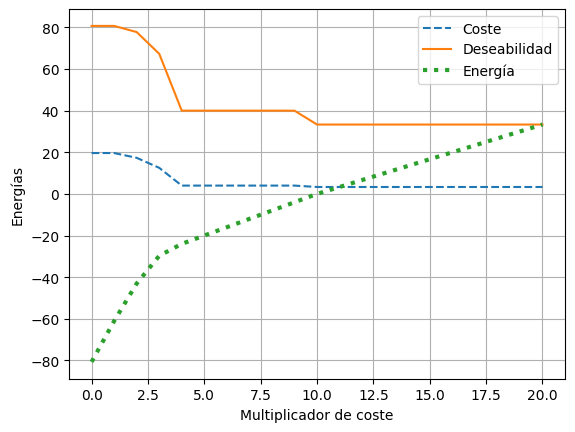

In [35]:
%matplotlib inline

vector_coste, vector_deseable, vector_energia = [], [], []

for ind in range(len(vector_graf)):
    vector_coste.append(vector_graf[ind][0])
    vector_deseable.append(vector_graf[ind][1])
    vector_energia.append(vector_graf[ind][2])

plt.plot(vector_coste,ls = "--")
plt.plot(vector_deseable,ls = "-")
plt.plot(vector_energia,ls = ":",lw=3)
plt.legend(["Coste","Deseabilidad","Energía"])
plt.xlabel("Multiplicador de coste")
plt.ylabel("Energías")
plt.grid()
plt.show()

Parece ser que, cuando el coste tiene un multiplicador mayor de 5, la solución se rige en su mayor medida del coste de los alimentos, dejando atras la deseabilidad. Cuando $\alpha \geq 10$, las aportaciones se mantienen constantes, mientras que la energía va aumentando por el efecto de dicho multiplicador.